The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded custom basis: {'RF': 'esbe', 'U1': 'esbe2', 'U2': 'esbe3', 'U3': 'esbe4', 'U4': 'esbe5', 'U5': 'esbe6', 'U6': 'esbe7', 'U7': 'esbe8'}
加载自定义Basis设置
self.unit_l= 0.001
Isotope: Ba135
bound = 1000


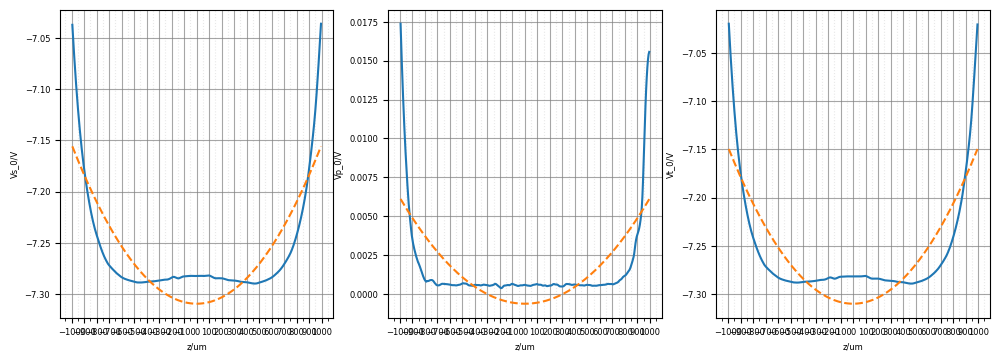

In [15]:
%load_ext autoreload
%autoreload 2
# import importlib
# import configure
# importlib.reload(configure)
import configure
import os

dirname = os.getcwd()
flag_smoothing=True #是否对导入的电势场格点数据做平滑化，如果True，那么平滑化函数默认按照下文def smoothing(data)
num_electrodes = 28
if num_electrodes == 28:
    filename=os.path.join(dirname, "../../../data/monolithic20241118.csv") #文件名：导入的电势场格点数据
    filename=os.path.join(dirname, "../../../data/28electrodes_sym_x60y40z1000_dx2dy2dz5.csv") #文件名：导入的电势场格点数据
    filename=os.path.join(dirname, "../../../data/28electrodes_sym4_x100y50z1000_dx2dy2dz5_CM62.csv")
    basis_filename=os.path.join(dirname, "electrode_basis_28.json")#文件名：自定义Basis设置 #可以理解为一种基矢变换，比如"U1"相当于电势场组合"esbe1"*0.5+"esbe1asy"*-0.5
    config_name = "flat_28"
elif num_electrodes == 60:
    filename=os.path.join(dirname, "../../../data/60electrodes_sym4_x100y50z1000_dx2dy2dz5_CM62.csv")
    basis_filename=os.path.join(dirname, "electrode_basis_60.json")
    config_name = "flat_60"
basis = configure.Data_Loader(filename, basis_filename, flag_smoothing)
basis.loadData()
# sym = True if num_electrodes == 60 else False
configure = configure.Configure(basis=basis, sym=False)
# configure.load_from_file(os.path.join(dirname, "../saves/saved_config_regression_0.01_1000.json"))
configure.load_from_file(os.path.join(dirname, "../saves/%s.json"%config_name))
Vs = configure.static_potential()
Vpp = configure.pseudo_potential()
Vt = Vs + Vpp
print("Isotope:", configure.isotope)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

shape = Vt.shape
ls_label = ['x', 'y', 'z']

bound = 1000
print("bound =", bound)

scan_range = bound
tick_stride = 100
minor_stride = 50
fontsize = 6

# scan_range = bound
# tick_stride = 10
# minor_stride = 5
# fontsize = 6


def R2(x,y):
    '''
    x: fit data
    y: raw data
    '''
    return 1-np.sum((x-y)**2)/np.sum((y-np.mean(y))**2)

def tf_scan(scan_id, ax_id, scan_loc=None, plot=False):
    '''
    scan_id: The direction of scan
    ax_id: The direction of trap freq
    scan_loc: The location of current scan
    '''
    id_list = [0, 1, 2]
    x = basis.coordinate_um[ax_id]
    if ax_id == scan_id:
        Vs_0 = np.take(np.take(Vs, [int(np.ceil(shape[(ax_id+1)%3]/2))], axis=(ax_id+1)%3), [int(np.ceil(shape[(ax_id+2)%3]/2))], axis=(ax_id+2)%3).flatten()
        Vp_0 = np.take(np.take(Vpp, [int(np.ceil(shape[(ax_id+1)%3]/2))], axis=(ax_id+1)%3), [int(np.ceil(shape[(ax_id+2)%3]/2))], axis=(ax_id+2)%3).flatten()
    else:
        id_list.remove(scan_id)
        id_list.remove(ax_id)
        left = id_list[0]
        Vs_0 = np.take(np.take(Vs, [scan_loc], axis=scan_id), [int(np.ceil(shape[left]/2))], axis=left).flatten()
        Vp_0 = np.take(np.take(Vpp, [scan_loc], axis=scan_id), [int(np.ceil(shape[left]/2))], axis=left).flatten()
    Vt_0 = Vs_0 + Vp_0
    ct = np.polyfit(x, Vt_0, 2)
    ta, tb, tc = ct
    if plot:
        cs = np.polyfit(x, Vs_0, 2)
        sa, sb, sc = cs
        cp = np.polyfit(x, Vp_0, 2)
        pa, pb, pc = cp
        Vs_fit = np.polyval(cs, x)
        Vp_fit = np.polyval(cp, x)
        Vt_fit = np.polyval(ct, x)
        fig, ax = plt.subplots(1,3,figsize=(12,4))
        mask = (x>=-bound) & (x<=bound)
        ax[0].plot(x[mask], Vs_0[mask],label='Static potential')
        ax[0].plot(x[mask], Vs_fit[mask],label='Quadratic fit', linestyle='--')
        ax[1].plot(x[mask], Vp_0[mask],label='Pseudo potential')
        ax[1].plot(x[mask], Vp_fit[mask],label='Quadratic fit', linestyle='--')
        ax[2].plot(x[mask], Vt_0[mask],label='Total potential')
        ax[2].plot(x[mask], Vt_fit[mask],label='Quadratic fit', linestyle='--')
        ax[0].set_xlabel('%s/um'%(ls_label[ax_id]), fontsize=fontsize)
        ax[0].set_ylabel('Vs_0/V', fontsize=fontsize)
        ax[0].tick_params(axis='x', labelsize=fontsize)
        ax[0].tick_params(axis='y', labelsize=fontsize)
        # ax[0].legend(title=f'$R^2$ = {R2(Vs_fit, Vs_0):.4f}\n y = {sa:.2e}x² + {sb:.2e}x + {sc:.2e}')
        ax[1].set_xlabel('%s/um'%(ls_label[ax_id]), fontsize=fontsize)
        ax[1].set_ylabel('Vp_0/V', fontsize=fontsize)
        ax[1].tick_params(axis='x', labelsize=fontsize)
        ax[1].tick_params(axis='y', labelsize=fontsize)
        # ax[1].legend(title=f'$R^2$ = {R2(Vp_fit, Vp_0):.4f} \n y = {pa:.2e}x² + {pb:.2e}x + {pc:.2e}')
        ax[2].set_xlabel('%s/um'%(ls_label[ax_id]), fontsize=fontsize)
        ax[2].set_ylabel('Vt_0/V', fontsize=fontsize)
        ax[2].tick_params(axis='x', labelsize=fontsize)
        ax[2].tick_params(axis='y', labelsize=fontsize)
        # ax[2].legend(title=f'$R^2$ = {R2(Vt_fit, Vt_0):.4f} \n y = {ta:.2e}x² + {tb:.2e}x + {tc:.2e}')
        for i in range(3):
            ax[i].set_xticks(np.arange(-scan_range, scan_range+tick_stride, tick_stride))
            ax[i].xaxis.set_minor_locator(MultipleLocator(minor_stride))
            ax[i].grid(True, which='major', linestyle='-', color='gray', alpha=0.7)  # 主刻度网格
            ax[i].grid(True, which='minor', linestyle=':', color='lightgray', alpha=0.5)  # 次刻度网格
    return np.sqrt(2*ta/configure.m*configure.ec)
# consider wy in z direction

ax_id, scan_id = 0, 2
ax_id = scan_id = 2
if ax_id == scan_id:
    tf_scan(scan_id, ax_id, plot=True)
else:
    mask = (basis.coordinate_um[scan_id]>=-bound) & (basis.coordinate_um[scan_id]<=bound)
    wy = np.zeros(shape[scan_id])
    for z_id in range(shape[scan_id]):
        wy[z_id] = tf_scan(scan_id, ax_id, z_id)/(2*np.pi)
    plt.plot(basis.coordinate_um[scan_id][mask], wy[mask]) 
    plt.xlabel("%s/um"%ls_label[scan_id])
    plt.ylabel("f%s/MHz"%ls_label[ax_id])
    plt.xticks(np.arange(-scan_range, scan_range+tick_stride, tick_stride), fontsize=fontsize)
    plt.gca().xaxis.set_minor_locator(MultipleLocator(minor_stride))
    plt.grid(True, which='major', linestyle='-', color='gray', alpha=0.7)  # 主刻度网格
    plt.grid(True, which='minor', linestyle=':', color='lightgray', alpha=0.5)  # 次刻度网格
    plt.show()

In [18]:
import numpy as np

a = [np.arange(3), np.arange(3)]
print(np.array(a).ndim)

2


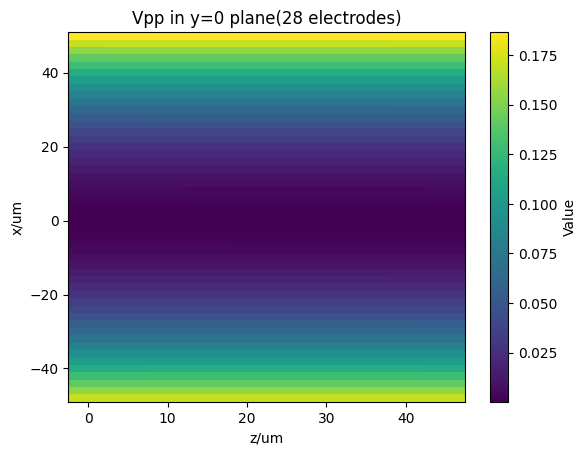

In [ ]:
coord_x = basis.coordinate_um[0]
coord_y = basis.coordinate_um[1]
coord_z = basis.coordinate_um[2]
# mask_x = (coord_x>-bound) & (coord_x<bound) 
mask_x = (coord_x>-50) & (coord_x<50)
mask_z = (coord_z<50) & (coord_z>=0)
y_mid = int(np.ceil(shape[1]/2))
Vpp_y0 = Vpp[:, y_mid, :][np.ix_(mask_x, mask_z)]
Vs_y0 = Vs[:, y_mid, :][np.ix_(mask_x, mask_z)]
Vt_y0 = Vpp_y0 + Vs_y0
plt.figure()
pc = plt.pcolormesh(coord_z[mask_z], coord_x[mask_x], Vpp_y0, shading='auto', cmap='viridis')
plt.colorbar(pc, label='Value')
plt.xlabel('z/um')
plt.ylabel('x/um')
plt.title('Vpp in y=0 plane(28 electrodes)')
plt.show()

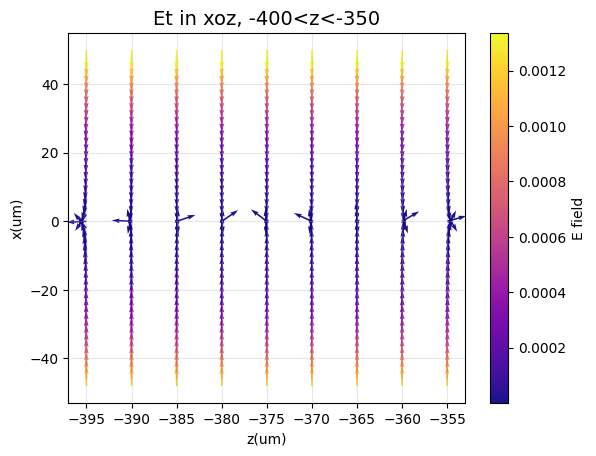

In [35]:
# E field
mask_x = (coord_x>-50) & (coord_x<50)
mask_z = (coord_z<-350) & (coord_z>=-400)
y_mid = int(np.ceil(shape[1]/2))
Vpp_y0 = Vpp[:, y_mid, :][np.ix_(mask_x, mask_z)]
Vs_y0 = Vs[:, y_mid, :][np.ix_(mask_x, mask_z)]
Vt_y0 = Vpp_y0 + Vs_y0
Z, X = np.meshgrid(coord_z[mask_z], coord_x[mask_x])
Ex, Ez = np.gradient(-Vt_y0, coord_x[mask_x], coord_z[mask_z], edge_order=2)
E_mag = np.sqrt(Ex**2 + Ez**2)
q = plt.quiver(Z,X, Ez/E_mag, Ex/E_mag,
               E_mag,          # 用场强决定颜色
               cmap='plasma',      # 好看的颜色：'viridis','plasma','hot','coolwarm'
               scale=20,
               width=0.004,
               alpha=0.95)
plt.colorbar(q, label='E field')
plt.title('Et in xoz, -400<z<-350', fontsize=14)
plt.xlabel('z(um)')
plt.ylabel('x(um)')
plt.grid(True, alpha=0.3)
# plt.gca().set_aspect('equal')
plt.show()

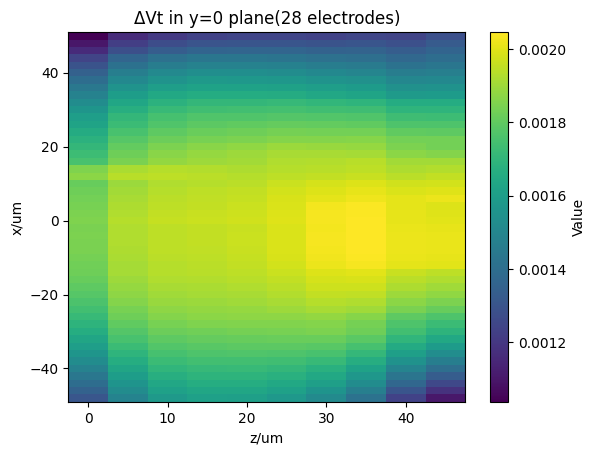

In [19]:
coord_x = basis.coordinate_um[0]
coord_y = basis.coordinate_um[1]
coord_z = basis.coordinate_um[2]
# mask_x = (coord_x>-bound) & (coord_x<bound) 
mask_x = (coord_x>-50) & (coord_x<50)
mask_z0 = (coord_z<50) & (coord_z>=0)
mask_z1 = (coord_z<400) & (coord_z>350) #保证作差的两个数组size相同
y_mid = int(np.ceil(shape[1]/2))
Vpp_y0 = Vpp[:, y_mid, :][np.ix_(mask_x, mask_z0)]
Vs_y0 = Vs[:, y_mid, :][np.ix_(mask_x, mask_z0)]
Vt_y0 = Vpp_y0 + Vs_y0
Vpp_y1 = Vpp[:, y_mid, :][np.ix_(mask_x, mask_z1)]
Vs_y1 = Vs[:, y_mid, :][np.ix_(mask_x, mask_z1)]
Vt_y1 = Vpp_y1 + Vs_y1
plt.figure()
pc = plt.pcolormesh(coord_z[mask_z0], coord_x[mask_x], Vt_y0-Vt_y1, shading='auto', cmap='viridis')
plt.colorbar(pc, label='Value')
plt.xlabel('z/um')
plt.ylabel('x/um')
plt.title('ΔVt in y=0 plane(28 electrodes)')
plt.show()

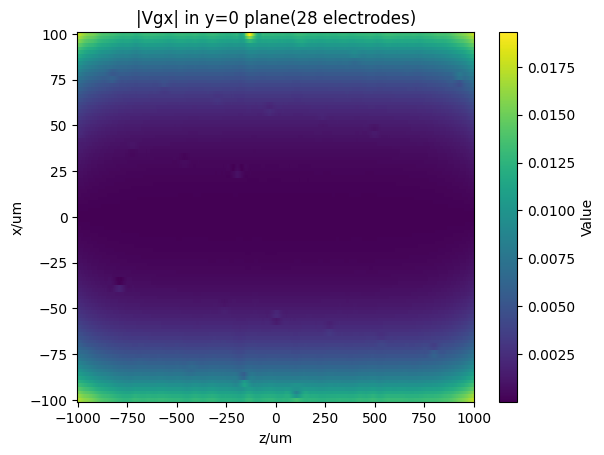

In [15]:
# from scipy.ndimage import gaussian_filter
# f_smooth = gaussian_filter(Vt_y0, sigma=1.0)
Vgx, Vgz = np.gradient(Vt_y0, coord_x[mask], coord_z, edge_order=2)
plt.figure()
pc = plt.pcolormesh(coord_z, coord_x[mask], np.abs(Vgx), shading='auto', cmap='viridis')
plt.colorbar(pc, label='Value')
plt.xlabel('z/um')
plt.ylabel('x/um')
plt.title('|Vgx| in y=0 plane(28 electrodes)')
plt.show()

201
36


np.float64(13.338949481752424)

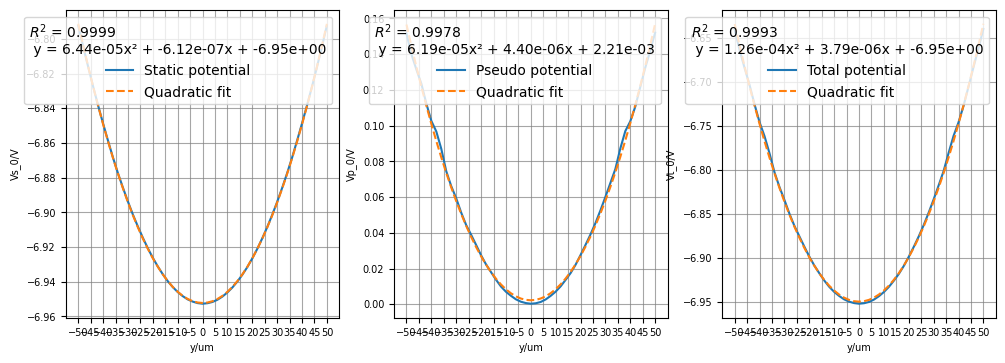

In [59]:
z_loc = 220 # in unit of um
dz = basis.coordinate_um[2][1] - basis.coordinate_um[2][0]
z_loc /= dz
print(len(basis.coordinate_um[2]))
print(int(z_loc))
ax_id = 1
scan_id = 2
tf_scan(scan_id, ax_id, z_loc, plot=True)


In [4]:
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import psutil

with ProcessPoolExecutor() as executor:
    max_workers = executor._max_workers
    print(f"最大并行进程数: {max_workers}")
    parent = psutil.Process()  # 当前 Python 进程
    children = parent.children(recursive=True)  # 获取所有子进程
    print(f"当前运行的子进程数 by psutil: {len(children)}")
    time.sleep(0.1)  # 短暂等待以确保子进程启动
    active_processes = len(multiprocessing.active_children())
    print(f"当前活跃进程数 by multiprocessing: {active_processes}")

最大并行进程数: 208
当前运行的子进程数 by psutil: 0
当前活跃进程数 by multiprocessing: 0


In [5]:
# Use Vpp to calculate eq_pos

from scipy.interpolate import RegularGridInterpolator
from scipy.constants import e, Boltzmann
import os

flag_smoothing=True #是否对导入的电势场格点数据做平滑化，如果True，那么平滑化函数默认按照下文def smoothing(data)
filename=os.path.join(dirname, "../../../data/monolithic20241118.csv") #文件名：导入的电势场格点数据
basis_filename=os.path.join(dirname, "electrode_basis.json")#文件名：自定义Basis设置 #可以理解为一种基矢变换，比如"U1"相当于电势场组合"esbe1"*0.5+"esbe1asy"*-0.5
basis = Data_Loader(filename, basis_filename, flag_smoothing)
basis.loadData()
configure = Configure(basis=basis)
# configure.load_from_file(os.path.join(dirname, "../saves/saved_config_regression_0.01_1000.json"))
configure.load_from_file(os.path.join(dirname, "../saves/10000.json"))
Vs = configure.static_potential()
Vpp = configure.pseudo_potential()
Vt = Vs + Vpp
Vt -= np.min(Vt)    # Take the energy minimum as potential zero point
Vt *= e/Boltzmann   # Use K as the unit of Energy

grid_x, grid_y, grid_z = basis.coordinate_um
print(max(grid_z))
Vt_itp = RegularGridInterpolator((grid_x, grid_y, grid_z), Vt, bounds_error=True)

def energy(r):
    N_ions = r.shape[0]
    return sum(Vt_itp(r[i,:]) for i in range(N_ions))

def gradient(r):
    N_ions = r.shape[0]
    DIM = r.shape[1]
    eps = 1e-4
    grad = np.zeros(N_ions*DIM)
    for id in range(N_ions):
        for dim in range(DIM):
            r_plus = r_minus = r
            r_plus[id, dim] += eps
            r_minus[id, dim] -= eps
            grad[id*DIM+dim] = (energy(r_plus) + energy(r_minus))/(2*eps)
    return grad

Loaded custom basis: {'RF': 'esbe', 'U1': 'esbe1', 'U2': 'esbe2', 'U3': 'esbe3', 'U4': 'esbe4', 'U5': 'esbe5', 'U6': 'esbe6', 'U7': 'esbe7'}
加载自定义Basis设置
self.unit_l= 0.001
600.0


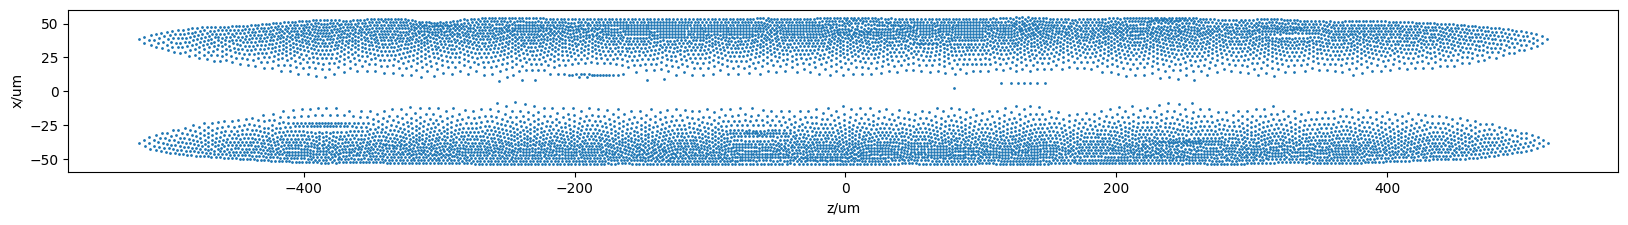

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

r = np.load("../data_cache/ion_pos/10000/timestamp5541&time49.998us.npy")
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(r[:, 2], r[:, 0], s=1)
ax.set_xlabel("z/um")
ax.set_ylabel("x/um")
ax.set_aspect("equal")
plt.show()

# print(energy(r))
# start = time.time()
# print(gradient(r).shape)
# end = time.time()
# print(end-start)

11084 11084
max_freq: 110.81538965069075


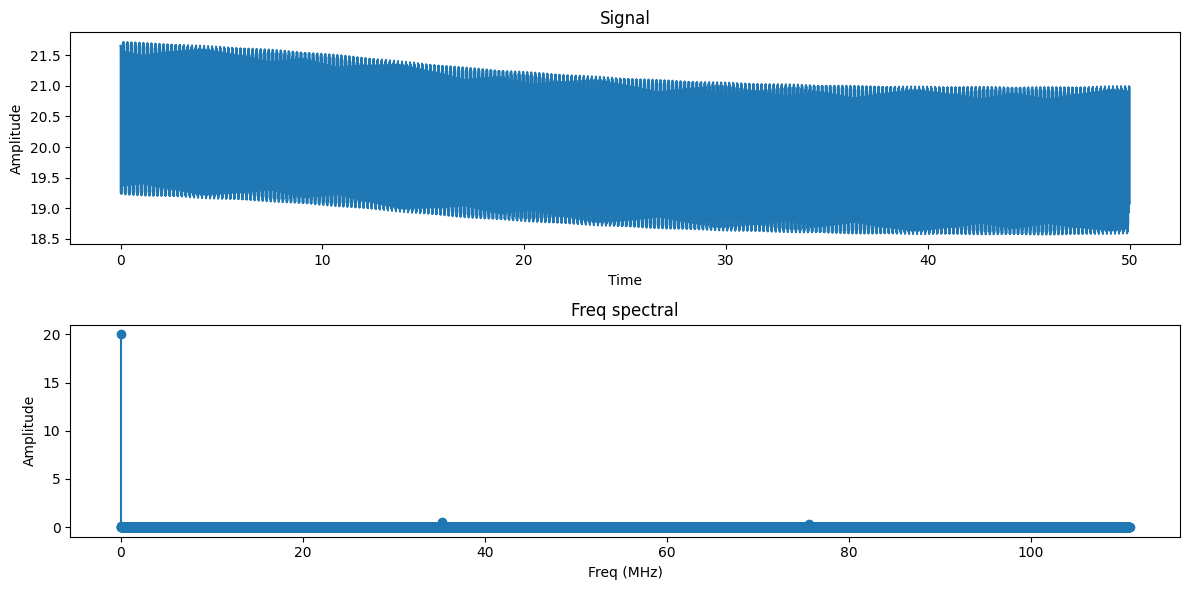

In [11]:
# Sequence analyse
import numpy as np
import os

dir_path = "../data_cache/ion_pos/10000/"
items = os.listdir(dir_path)
# 仅统计文件（排除子文件夹）
files = [item for item in items if os.path.isfile(os.path.join(dir_path, item))]
Nf = len(files)
print(Nf, Nf//2*2)
Dt = configure.dt*1e6
seq = np.zeros(Nf//2*2)
Nth = 0
ax_ion = 0
for idx in range(Nf):
    timestamp = idx//2
    if idx//2 == 0:
        real_t = timestamp
    else:
        real_t = timestamp+0.5
    _time = real_t*Dt
    # consider 0th ion
    try:
        r = np.load(dir_path+"timestamp%d&time%.3fus.npy"%(timestamp, _time))
    except:
        print(idx)
        break
    seq[idx] = r[Nth, ax_ion]    # Nth ion's motion on ax_ion's direction
t_seq = Dt/2*np.arange(Nf)

fs = 2/Dt # Sampling frequency
freq = np.fft.fft(seq)
Ns = len(freq)
freqs = np.fft.fftfreq(Ns, 1/fs)  # 频率轴
magnitude = np.abs(freq) / Ns  # 幅度谱（归一化）

# 只绘制正频率部分
half_Ns = Ns // 2
freqs = freqs[:half_Ns]
magnitude = magnitude[:half_Ns]

print("max_freq:", max(freqs))

# 绘制时域信号
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_seq, seq)
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# 绘制频域幅度谱
plt.subplot(2, 1, 2)
plt.stem(freqs, magnitude, basefmt=" ")
plt.title("Freq spectral")
plt.xlabel("Freq (MHz)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

